In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [3]:
# region_id = 5883 # freiburtg
# region_id = 69333 # prague

# region_id = 139196 # prague

region_id = 151676

In [4]:

etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/chars/tessellations_chars_{region_id}.parquet')
tess = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/chars/tessellations_chars_{region_id}.parquet')
buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/chars/buildings_chars_{region_id}.parquet')
streets = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/chars/streets_chars_{region_id}.parquet')
nodes = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/chars/nodes_chars_{region_id}.parquet')
primary = pd.read_parquet(f'/data/uscuni-ulce/processed_data/chars/primary_chars_{region_id}.parquet')

In [5]:
model_params = '_75_0_None_None_False'

In [6]:
# streets.explore()

In [7]:
def morphotopes_to_etcs(region_id, etcs=True, model_params='_100_0_None_None_False'):

    if etcs:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

    else:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')
        
    etcs['label'] = -1
    
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

    morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
    etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
    etcs['morph'] = str(region_id) + '_' + '-1'
    etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values
    return etcs

In [8]:
etcs = morphotopes_to_etcs(region_id, model_params=model_params)

In [9]:
primary['morph'] = etcs['morph']

In [10]:
%%time
morph_chars = primary.groupby('morph').agg('median')
morphotopes = morph_chars[morph_chars.index.str.split('_').str[-1] != '-1']

CPU times: user 236 ms, sys: 1.23 ms, total: 238 ms
Wall time: 237 ms


In [11]:
# morphotopes['libBAS'] = res['libBAS']
# morphotopes['libBPS'] = res['libBPS']
# # morphotopes['libBES'] = res['libBES']

In [12]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
component_data = morphotopes

vals = QuantileTransformer(subsample=None).fit_transform(component_data)
# vals = StandardScaler().fit_transform(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)


# component_data = component_data.clip(-10, 10)

In [13]:
to_drop = []
to_drop = ['stcSAl','stbOri','stcOri',
           'ldkAre', 'ldkPer', 'lskCCo', 'lskERI',
           'lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
          'licBAD',
          'misBAD',
           'ssbCCM',
           'ssbCCD',
           
           # 'mtbSWR',
           # 'ltcBuA',
           # 'ldbPWL', 
           # 'mtbNDi', 
           # 'ltbIBD',
           # 'sdbAre',
           # 'sdbPer'

           # 'mibLen',	'mibElo',	'mibERI',	'mibCCo',	'mibLAL',
          ]

# # to_drop = ['stcSAl','stbOri','stcOri','stbCeA', 
# #            'ldkAre', 'ldkPer', 'lskCCo', 'lskERI',
# #            'lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
# #           'licBAD', 
# #           'micBAD', 
# #            'mibLAL', 
# #            'mibAre', 
# #            'mibLen', 
# #            'sscCCo']


# to_drop = ['sdbAre',
#  'sdbPer',
#  'ssbCCo',
#  'ssbCor',
#  'ssbSqu',
#  'ssbERI',
#  'ssbElo',
#  'ssbCCM',
#  'ssbCCD',
#  'stbOri',
#  'stbCeA',
#  'stbSAl',
#  'sdsLen',
#  'sssLin',
#  'sisBpM',
#  'sdsSPW',
#  'sdsSPO',
#  'sdsSWD',
#  'sddAre',
#  'stcOri',
#  'sdcLAL',
#  'sdcAre',
#  'sscCCo',
#  'sscERI',
#  'sicCAR',
#  'stcSAl',
#  'sdsAre']



In [14]:

component_data = component_data.drop(columns=to_drop)

In [15]:
component_data.describe().loc['min', ].min(), component_data.describe().loc['max', ].max()

(np.float64(0.0), np.float64(1.0))

In [16]:
component_data.shape


(1920, 59)

In [17]:
component_data.columns

Index(['sdbAre', 'sdbPer', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo',
       'mtbSWR', 'libNCo', 'ldbPWL', 'ltcBuA', 'mtbAli', 'mtbNDi', 'ltbIBD',
       'stbCeA', 'stbSAl', 'sdsLen', 'sssLin', 'ldsMSL', 'ldsRea', 'ldsAre',
       'sisBpM', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'mtdDeg', 'lcdMes', 'linP3W',
       'linP4W', 'linPDE', 'lcnClo', 'lddNDe', 'linWID', 'ldsCDL', 'xcnSCl',
       'mtdMDi', 'sddAre', 'midRea', 'midAre', 'sdcLAL', 'sdcAre', 'sscCCo',
       'sscERI', 'mtcWNe', 'mdcAre', 'ltcWRB', 'sicCAR', 'sdsAre', 'mibCou',
       'mibAre', 'mibLen', 'mibElo', 'mibERI', 'mibCCo', 'mibLAL', 'mibFR',
       'mibSCo', 'micBAD', 'midBAD'],
      dtype='object')

In [18]:
from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, fcluster

In [19]:
# umap_metric ='euclidean'
# n_neighbors = 5

# import umap
# import umap.plot
# reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, metric=umap_metric, verbose=False, random_state=1)
# emb = reducer.fit_transform(component_data)
# umap.plot.points(reducer)

In [20]:
# reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=20, 
#                     min_dist=0, 
#                     metric=umap_metric, verbose=True, random_state=1)
# embedding = reducer.fit_transform(component_data)

In [21]:
# tr_data = embedding
tr_data = component_data

In [22]:
final_linkage = 'complete'
final_metric = 'euclidean'

In [23]:
clusterer = AgglomerativeClustering(linkage=final_linkage,
                                    metric=final_metric,
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(tr_data)
linkage_matrix = get_linkage_matrix(model)

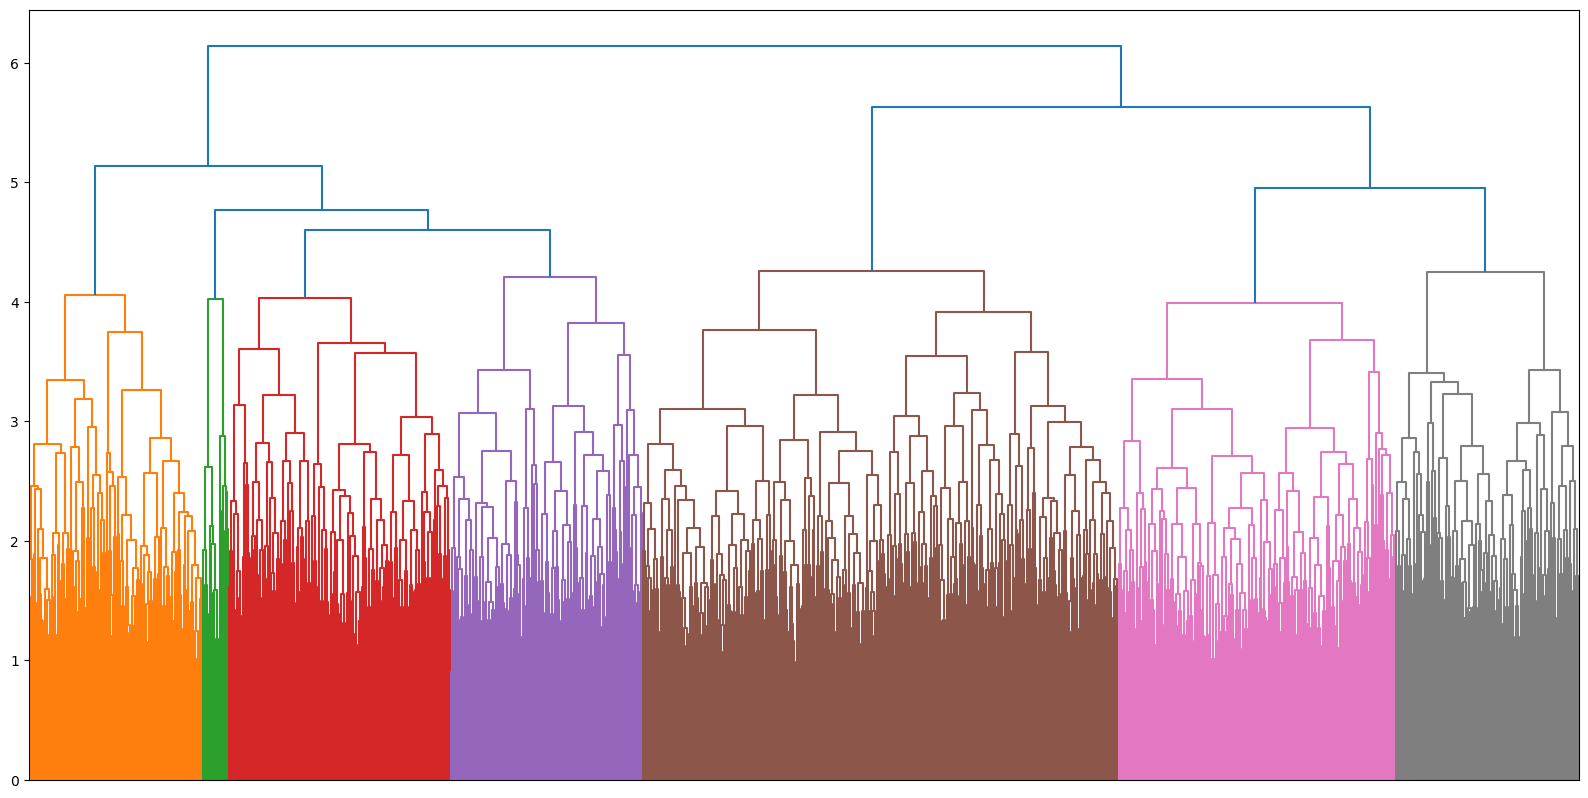

In [24]:
fig,ax = plt.subplots(figsize=(20,10))
_ = dendrogram(linkage_matrix, ax=ax, no_labels=True)

In [25]:
cutoff = 2.5

In [26]:
clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
np.unique(clusters)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134], dtype=int32)

In [27]:
pd.Series(clusters, component_data.index).value_counts()

65     52
71     50
100    48
64     43
98     43
       ..
72      2
59      2
12      2
11      1
10      1
Name: count, Length: 134, dtype: int64

In [28]:


# component_data.groupby(clusters.astype(str)).mean().style.background_gradient(axis=0, cmap="BuGn")

In [29]:
# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# clusters = KMeans(n_clusters=30, max_iter=5000, n_init=300, random_state=1).fit(tr_data).labels_
# np.unique(clusters)


# clusterer = AgglomerativeClustering(linkage='complete',
#                                     metric='euclidean',
#                                     compute_full_tree=True,
#                                     compute_distances=True)

# model = clusterer.fit(component_data.groupby(clusters).agg(['median']))
# linkage_matrix = get_linkage_matrix(model)
# fig,ax = plt.subplots(figsize=(10,10))
# _ = dendrogram(linkage_matrix, ax=ax, leaf_rotation=45)

# component_data.groupby(clusters).agg('median').loc[[10, 16, 5]].style.background_gradient(axis=0, cmap="BuGn")

In [30]:

cluster_map = pd.Series(-1, index=morph_chars.index)
cluster_map.loc[morphotopes.index.values] = clusters

In [31]:
%%time
plotting = etcs.copy()
plotting['label'] = plotting.morph.map(cluster_map.to_dict())
plotting['geometry'] = plotting.simplify(1)

CPU times: user 8.86 s, sys: 6.31 ms, total: 8.86 s
Wall time: 8.86 s


#### ETCs

In [67]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
# layer = lonboard.SolidPolygonLayer.from_geopandas(tessellation[tessellation.index >= 0], opacity=.08)
layer = lonboard.SolidPolygonLayer.from_geopandas(plotting, opacity=.08)

CPU times: user 942 ms, sys: 37.1 ms, total: 979 ms
Wall time: 978 ms


In [605]:

from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [606]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(plotting.label)

#### Buildings

In [32]:
def morphotopes_to_etcs(region_id, etcs=True, model_params='_100_0_None_None_False'):

    if etcs:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

    else:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')
        
    etcs['label'] = -1
    
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

    morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
    etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
    etcs['morph'] = str(region_id) + '_' + '-1'
    etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values
    return etcs

In [33]:
# etcs=False to read buildings, etcs=True for tessellation cells.
etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)
etcs['final'] = plotting.morph.map(cluster_map.to_dict())

etcs['geometry'] = etcs.simplify(1).to_crs(epsg=4326).make_valid()
etcs = etcs[etcs['geometry'].geom_type == 'Polygon']

In [34]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

CPU times: user 1.22 s, sys: 155 ms, total: 1.38 s
Wall time: 1.37 s


In [35]:

from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters ')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

In [36]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(etcs['final'])

In [73]:
res.describe()

NameError: name 'res' is not defined

In [625]:
res.loc[['151676_568_51','151676_568_670','151676_2488_0', '151676_568_584', '151676_568_354', '151676_568_349', '151676_568_27']]

,libBAS,libBPS,libBES
morph,,,
151676_568_51,519.346623,27.296888,0.019423
151676_568_670,798.801909,36.681569,0.029465
151676_2488_0,1032.012826,41.282464,0.025876
151676_568_584,177.001755,14.478243,0.017604
151676_568_354,127.319638,12.973436,0.027573
151676_568_349,125.666107,15.238323,0.019312
151676_568_27,92.403370,14.622560,0.029060


In [74]:
component_data.loc[['151676_568_51','151676_568_670','151676_568_606', '151676_568_584', '151676_568_354', '151676_568_27']].style.background_gradient(axis=1, cmap="BuGn")


,sdbAre,sdbPer,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,libNCo,mtbAli,mtbNDi,ltbIBD,stbCeA,stbSAl,sdsLen,sssLin,ldsMSL,ldsRea,ldsAre,sisBpM,sdsSPW,sdsSPO,sdsSWD,mtdDeg,lcdMes,linP3W,linP4W,linPDE,lcnClo,lddNDe,linWID,ldsCDL,xcnSCl,mtdMDi,sddAre,midRea,midAre,sdcLAL,sdcAre,sscCCo,sscERI,mtcWNe,mdcAre,ltcWRB,sicCAR,sdsAre,mibCou,mibAre,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD
morph,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
151676_568_51,0.985891,0.983919,0.026066,0.000000,0.120579,0.623761,0.015485,0.000000,0.207662,0.691478,0.691636,0.080901,0.040463,0.739854,0.887937,0.685365,0.903075,0.906665,0.231550,0.948937,0.773093,0.037924,1.000000,0.694695,0.411912,0.583584,0.529530,0.508799,0.354346,0.376367,0.791517,0.731732,0.814928,0.865152,0.949994,0.945659,0.855666,0.902097,0.385675,0.343743,0.160996,0.933310,0.048144,0.968679,0.821439,0.000000,0.989075,0.985630,0.029943,0.032902,0.031884,0.985976,0.997902,0.997902,0.996369,0.990271
151676_568_670,0.979076,0.973428,0.047287,0.000000,0.785805,0.594594,0.027154,0.000000,0.344445,0.956706,0.877790,0.275437,0.460785,0.758671,1.000000,0.702542,0.560561,0.869563,0.361101,0.995971,0.991877,0.005148,0.511512,0.307808,0.544545,0.313313,0.631632,0.315308,0.375530,0.350842,0.786810,0.000000,0.843694,0.869302,0.635135,0.920918,0.963992,0.977726,0.386470,0.322226,0.039817,0.997957,0.001377,0.772391,0.863952,0.000000,0.961015,0.958173,0.037003,0.403267,0.072010,0.958108,0.964001,0.964001,0.998363,0.999635
151676_568_606,0.995022,0.988994,0.012002,0.000000,0.990022,0.342985,0.014878,0.000000,0.634638,0.948931,0.880786,0.584617,0.760798,0.793015,0.526104,0.692487,0.728729,0.923837,0.138837,0.980871,0.954808,0.353440,0.511512,0.675500,0.800305,0.746246,0.069806,0.648323,0.392441,0.475725,0.000000,0.000000,0.797346,0.876083,0.806306,0.969247,0.981411,0.995972,0.661344,0.400685,0.050035,0.996062,0.039033,0.777693,0.822643,0.000000,0.977048,0.972951,0.022416,0.370431,0.029897,0.976248,0.982806,0.982806,0.985959,0.996917
151676_568_584,0.982733,0.980372,0.003965,0.000000,0.764218,0.885637,0.001063,0.000000,0.942568,0.973930,0.936938,0.467270,0.557573,0.687242,0.465422,0.645622,0.483984,0.882117,0.109526,1.000000,1.000000,0.014885,0.511512,0.723817,0.304805,0.862863,0.321822,0.588649,0.337260,0.391358,0.384384,0.000000,0.793763,0.880962,0.690190,0.908052,0.966010,0.976213,0.704504,0.334225,0.058027,0.987718,0.050007,0.673849,0.753822,0.000000,0.965217,0.964505,0.002124,0.402095,0.021857,0.966439,0.972919,0.972919,0.964951,0.969346
151676_568_354,0.995952,0.998186,0.002159,0.998498,0.931009,0.002942,0.003246,0.000000,0.680045,0.860920,0.910902,0.393259,0.495394,0.629821,0.437168,0.567444,0.345345,0.784784,0.043287,0.975288,0.692353,0.091164,0.511512,0.842843,0.630631,0.844075,0.095596,0.610709,0.398190,0.478456,0.224810,0.000000,0.559591,0.708702,0.235736,0.744671,0.940341,0.967958,0.442559,0.094431,0.066104,0.972084,0.087207,0.893978,0.645647,0.984484,0.992327,0.991703,0.024726,0.008218,0.002738,0.991877,0.979006,0.979006,0.976678,0.965969
151676_568_27,0.971930,0.984772,0.004938,0.966466,1.000000,0.000895,0.042067,0.999315,0.996444,0.000000,0.000000,0.013074,0.505484,0.038039,0.494771,0.029972,0.102603,0.103174,0.334915,0.000909,0.000170,0.178142,0.511512,0.934849,0.927928,0.670170,0.016517,0.999430,0.955270,0.989814,0.123123,0.000000,0.026099,0.065050,0.125626,0.145451,0.307995,0.178491,0.165698,0.000637,0.677012,0.331458,0.915969,1.000000,0.004752,1.000000,0.998948,0.999469,0.490225,0.000065,0.019162,0.997945,0.991878,0.991878,0.949476,0.938942


In [75]:
from core.utils import used_keys
used_keys['linPDE']

'local proportion of cul-de-sacs of street network'

In [149]:
x, y, z = component_data.loc['151676_568_51'], component_data.loc['151676_568_584'], component_data.loc['151676_568_349']

In [150]:
xy = (x - y).abs() 
yz = (y-z).abs()

In [151]:
np.sqrt((xy** 2).sum()), np.sqrt((yz** 2).sum())

(np.float64(1.8396819805483358), np.float64(1.9502297046172512))

In [152]:
(xy).sum(), (yz).sum()

(np.float64(8.267206492679954), np.float64(7.324090851175271))

In [153]:
component_data.columns[(yz < xy)]

Index(['ssbCCo', 'ssbSqu', 'ssbElo', 'stbCeA', 'stbSAl', 'sdsLen', 'sssLin',
       'ldsMSL', 'ldsRea', 'ldsAre', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'mtdDeg',
       'lcdMes', 'lcnClo', 'ldsCDL', 'xcnSCl', 'midRea', 'midAre', 'sdcLAL',
       'sdcAre', 'sscCCo', 'mtcWNe', 'mdcAre', 'sicCAR', 'mibAre', 'mibLen',
       'mibElo', 'mibLAL', 'mibFR', 'mibSCo', 'micBAD', 'midBAD'],
      dtype='object')

In [154]:
pd.DataFrame({'contiguous/non-contiguous apartments': yz[(yz < xy)], 'non_contiguous apartments / industry':  xy[(yz < xy)]}).style.format('{:.4f}')

,contiguous/non-contiguous apartments,non_contiguous apartments / industry
ssbCCo,0.0180,0.0221
ssbSqu,0.4510,0.6436
ssbElo,0.0060,0.0144
stbCeA,0.2387,0.3864
stbSAl,0.0391,0.5171
sdsLen,0.0215,0.0526
sssLin,0.0959,0.4225
ldsMSL,0.0091,0.0397
ldsRea,0.1527,0.4191
ldsAre,0.0082,0.0245


In [84]:
used_keys['mtbNDi'], used_keys['ltbIBD']

('mean distance between neighbouring buildings',
 'mean inter-building distance')

In [93]:
morph_clusters = plotting.morph.unique()
morph_clusters = pd.Series(np.arange(morph_clusters.shape[0]), morph_clusters)
plotting['morph_label'] = plotting.morph.map(morph_clusters.to_dict())

In [262]:
layer.get_fill_color = get_color(plotting.morph_label)

In [109]:
target_label = 4

In [49]:
plotting[plotting.label == target_label].explore(prefer_canvas=True, tiles='cartodb positron')

In [136]:
streets = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/chars/streets_chars_{region_id}.parquet')

0.0        LINESTRING (5267295.09 3643830.349, 5267288.93...
1.0        LINESTRING (5277593.057 3570482.272, 5277591.9...
2.0        LINESTRING (5277858.338 3570605.874, 5277840.3...
3.0        LINESTRING (5277644.157 3571726.654, 5277650.0...
4.0        LINESTRING (5278148.83 3571329.296, 5278149.97...
                                 ...                        
24151.0    LINESTRING (5305127.37 3649152.136, 5305125.38...
24152.0    LINESTRING (5305543.377 3618747.168, 5305545.2...
24153.0    LINESTRING (5277593.138 3570480.494, 5277593.0...
24155.0    LINESTRING (5267415.443 3643910.455, 5267415.9...
24156.0    LINESTRING (5266788.847 3644803.997, 5266799.1...
Name: geometry, Length: 24155, dtype: geometry

In [64]:
# m = etcs[etcs.final == 88].explore(tiles="cartodb dark matter")
# # m = streets.explore(m=m)
# m

In [ ]:
## increase similarity between 48 and 43, 
## increase similarity  644 and 661
## decrease between 48,43 and 644, 661

In [48]:
morphs = etcs[etcs.morph.str.split('_').str[-1] != '-1'].to_crs(epsg=3035)

In [49]:
buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/chars/buildings_chars_{region_id}.parquet')
buildings = buildings.loc[morphs.index]
buildings['morph'] = etcs['morph']

In [50]:
import momepy as mm
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.neighbors import KDTree

def morph_shape_differences(data):
    # morphotope shape data
    group_area = data.geometry.area
    group_perimeter = data.geometry.length
    group_eri = mm.equivalent_rectangular_index(data.geometry)
    morph_data = pd.DataFrame({'area': group_area, 'per':group_perimeter, 'eri': group_eri})

    # get the nearest buildings based on area, perimeter, eri
    # vals = QuantileTransformer(subsample=None).fit_transform(morph_data)
    vals = StandardScaler().fit_transform(morph_data)
    tree = KDTree(vals)
    dists, idxs = tree.query(vals, k=6)
    idxs = idxs[:, -1]

    # return the average differences between the closest buildings in those dimensions
    # return the average differences between the closest buildings in those dimensions
    area_difference = np.abs(morph_data.iloc[np.arange(idxs.shape[0]), 0].values - morph_data.iloc[idxs, 0].values)
    perimeter_difference = np.abs(morph_data.iloc[np.arange(idxs.shape[0]), 1].values - morph_data.iloc[idxs, 1].values)
    eri_difference = np.abs(morph_data.iloc[np.arange(idxs.shape[0]), 2].values - morph_data.iloc[idxs, 2].values)

    return pd.Series({'libBAS': np.median(area_difference), 'libBPS': np.median(perimeter_difference), 'libBES':eri_difference.mean()})

In [51]:
# res = morphs.groupby('morph').apply(morph_shape_differences)
res = buildings.groupby('morph').apply(morph_shape_differences)

# res['libBAS'] = res.libBAS.clip(res.libBAS.median(), None)
# res['libBPS'] = res.libBPS.clip(res.libBPS.median(), None)

/tmp/ipykernel_761371/3669040641.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = buildings.groupby('morph').apply(morph_shape_differences)


In [54]:
res.loc[['151676_568_51','151676_568_670','151676_568_606', '151676_568_401', '151676_568_584', '151676_568_354', '151676_568_27']]

,libBAS,libBPS,libBES
morph,,,
151676_568_51,91.904458,7.240432,0.019423
151676_568_670,164.846326,12.230201,0.029465
151676_568_606,40.346602,4.961084,0.024316
151676_568_401,62.705192,6.662558,0.021873
151676_568_584,8.670680,1.034806,0.017604
151676_568_354,43.433120,6.936010,0.027573
151676_568_27,57.586372,9.807478,0.029060


In [55]:
morphotopes.loc[['151676_568_51','151676_568_670','151676_2488_0', '151676_568_584', '151676_568_354', '151676_568_27']].style.background_gradient(axis=1, cmap="BuGn")


,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,ssbCCM,ssbCCD,stbOri,mtbSWR,libNCo,ldbPWL,ltcBuA,mtbAli,mtbNDi,ltbIBD,stbCeA,stbSAl,sdsLen,sssLin,ldsMSL,ldsRea,ldsAre,sisBpM,sdsSPW,sdsSPO,sdsSWD,mtdDeg,lcdMes,linP3W,linP4W,linPDE,lcnClo,lddNDe,linWID,ldsCDL,xcnSCl,mtdMDi,sddAre,midRea,midAre,stcOri,sdcLAL,sdcAre,sscCCo,sscERI,mtcWNe,mdcAre,ltcWRB,sicCAR,stcSAl,ldkAre,ldkPer,lskCCo,lskERI,lskCWA,ltkOri,ltkWNB,likWBB,sdsAre,likWCe,mibCou,mibAre,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,licBAD,misBAD,midBAD
morph,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
151676_568_51,530.700256,106.310811,0.000000,0.448191,4.000000,0.119891,1.000056,0.484535,18.000927,0.027826,17.421368,0.000000,0.000000,188.029308,0.923077,1.990228,22.638397,28.811155,3.251876,1.378680,516.367209,0.999957,391.641485,567.000000,2222270.604807,0.060035,42.114438,0.877049,2.367946,4.000000,0.112676,0.680000,0.106383,0.200000,0.000002,0.002399,0.004134,1119.424405,0.037037,495.503915,172843.811801,155.000000,553954.208737,17.830978,87.823059,2923.869227,0.473220,0.976008,0.030339,30971.546143,0.000014,0.208400,2.966907,439120.299397,2741.689879,0.342995,0.963908,676.392264,16.334288,0.002530,0.275407,146935.857678,0.000290,1.000000,1396.784646,198.692295,0.514755,0.910264,0.401481,69.913006,6.359581,6.359581,1492.610714,2115.092608,1426.272995,1137.505788
151676_568_670,442.457282,91.905866,0.000000,0.491749,4.000000,0.366981,1.000048,0.539969,16.082365,0.094905,33.597921,0.000000,0.000000,93.330360,1.000000,2.439140,35.679679,36.308560,5.370346,5.317132,540.835391,1.000000,407.067939,324.000000,1887490.230608,0.073960,49.971249,0.994505,0.714431,3.000000,0.064516,0.714286,0.058824,0.222222,0.000001,0.002493,0.003918,1104.656937,0.000000,563.183971,178809.330113,72.000000,485099.263901,33.587360,116.090871,4779.982750,0.473286,0.975457,0.022233,53064.792770,0.000006,0.126837,5.715328,2497237.038532,19809.283033,0.226371,0.350238,4390.220418,36.945508,0.000656,0.130141,178227.908055,0.000304,1.000000,451.917000,92.467646,0.541666,1.001423,0.500332,33.984915,4.443213,4.443213,2037.765575,3218.731947,1549.228981,2509.425458
151676_2488_0,614.022481,120.107267,0.000000,0.466547,6.000000,0.289421,0.980209,0.563677,19.381353,1.970957,42.867771,0.000000,0.000000,122.612152,1.000000,0.674875,30.099818,37.890735,2.192817,6.680895,1154.958026,0.952114,468.985970,187.000000,1244105.497258,0.054547,39.351288,0.945860,3.159808,1.000000,0.060606,0.825000,0.075000,0.105263,0.000000,0.001943,0.003518,1621.947358,0.000000,556.979636,171579.447205,19.000000,129694.471082,40.238533,97.473955,3597.216343,0.501597,0.988798,0.023954,47455.855457,0.000005,0.153814,7.781855,1670034.299729,6933.116669,0.265678,0.907239,2029.415011,43.670705,0.001731,0.291422,337228.561285,0.000143,1.000000,663.652568,121.670052,0.572573,0.982969,0.451252,46.335112,5.261558,5.261558,2875.180649,5960.760999,4150.498631,2601.145051
151676_568_584,473.067192,102.631091,0.000000,0.356138,4.000000,0.362125,1.000170,0.334024,18.407539,0.041874,9.070934,0.000000,0.000000,104.110631,1.000000,5.722385,37.577009,41.092959,6.927448,6.440275,452.355483,0.986033,357.649358,294.000000,1993147.971058,0.046792,50.000000,1.000000,1.649608,3.000000,0.117117,0.652174,0.189655,0.155172,0.000002,0.002292,0.004291,402.993898,0.000000,463.775760,192420.883198,78.000000,449132.692165,18.227393,116.387735,4702.942390,0.503165,0.975798,0.023742,41460.781912,0.000014,0.112217,8.061340,397790.751158,2890.594891,0.540994,0.877817,461.092715,9.053230,0.002422,0.118551,114669.605767,0.000158,1.000000,485.298078,103.311673,0.336062,1.001394,0.360169,41.231338,4.740251,4.740251,457.727414,1145.251557,454.413011,599.192518
151676_568_354,683.534688,146.849167,0.000000,0.333968,20.000000,0.395149,0.847443,0.374803,19.208815,5.622645,11.114008,0.046140,0.000000,374.383439,0.750000,3.610224,28.279938,38.471468,6.395829,5.691142,401.533533,0.983704,296.538838,245.000000,1415316.937944,0.03

In [499]:
data = buildings.groupby('morph').get_group('151676_568_354')

In [500]:
data = data[~data['mibAre'].duplicated()]
group_area = data['mibAre']
group_perimeter = data['mibLen']
morph_data = pd.DataFrame({'area': group_area, 'per':group_perimeter})

# get the nearest buildings based on area, perimeter, eri
# vals = QuantileTransformer(subsample=None).fit_transform(morph_data)
vals = StandardScaler().fit_transform(morph_data)
tree = KDTree(vals)
dists, idxs = tree.query(vals, k=3)
# idxs = idxs[:, -1]

# # return the average differences between the closest buildings in those dimensions
# area_difference = np.abs(morph_data.iloc[np.arange(idxs.shape[0]), 0].values - morph_data.iloc[idxs, 0].values)
# perimeter_difference = np.abs(morph_data.iloc[np.arange(idxs.shape[0]), 1].values - morph_data.iloc[idxs, 1].values)

In [501]:
data.iloc[idxs[3]].explore()


In [378]:
morph_data = pd.DataFrame({'area': group_area, 'per':group_perimeter, 'eri': group_eri})

In [379]:
morph_shape_stats = morph_data.describe(percentiles=[.1, .9])
rep_morhp_data = morph_data[
((morph_shape_stats.loc['10%', 'area'] < morph_data.area)  & ( morph_data.area < morph_shape_stats.loc['90%', 'area']))
& ((morph_shape_stats.loc['10%', 'per'] < morph_data.per)  & ( morph_data.per < morph_shape_stats.loc['90%', 'per']))
& ((morph_shape_stats.loc['10%', 'eri'] < morph_data.eri)  & ( morph_data.eri < morph_shape_stats.loc['90%', 'eri']))
]

In [380]:
rep_morhp_data = morph_data

In [383]:
from sklearn.neighbors import KDTree

In [384]:
vals = QuantileTransformer(subsample=None).fit_transform(rep_morhp_data)
tree = KDTree(vals)
dists, idxs = tree.query(vals, k=2)
idxs = idxs[:, 1]

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (166). n_quantiles is set to n_samples.
  warnings.warn(


In [387]:
area_difference = np.abs(rep_morhp_data.iloc[np.arange(idxs.shape[0]), 0].values - rep_morhp_data.iloc[idxs, 0].values)
perimeter_difference = np.abs(rep_morhp_data.iloc[np.arange(idxs.shape[0]), 1].values - rep_morhp_data.iloc[idxs, 1].values)
eri_difference = np.abs(rep_morhp_data.iloc[np.arange(idxs.shape[0]), 2].values - rep_morhp_data.iloc[idxs, 2].values)

In [391]:
area_difference.mean(), perimeter_difference.mean(), eri_difference.mean()

(np.float64(69.54582429870656),
 np.float64(7.335218123130635),
 np.float64(0.01101264525265746))